In [1]:
import random
import equadratures as eq
import numpy as np
import matplotlib.pyplot as plt
from ModelTree import ModelTree
from sklearn.metrics import mean_squared_error
import scipy.stats as st

In [2]:
def sample(N, f, sample_from):
    X, y = [], []
    for i in range(N):
        x = sample_from[0] + random.random() * (sample_from[1] - sample_from[0])
        X.append(np.array(x))
        y.append(np.array(f(x, True)))
    return np.array(X), np.array(y)

In [3]:
def evaluate(model, f, sample_from):
    X, y = sample(30, f, sample_from)
    X = np.reshape(X, (X.shape[0], 1))
    y = np.reshape(y, (y.shape[0], 1))

    return mean_squared_error(y, model.predict(X))

In [36]:
def plot(models, f, X_train, y_train):
    
    x_test = np.reshape(np.linspace(-.5, 1.5, 100), (100, 1))
    X_train = np.reshape(X_train, (X_train.shape[0], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    plt.scatter(X_train[:,0], y_train[:,0], marker='o', s=80, color='blue', label='Training data')
    
    plt.plot(x_test, [f(x, False) for x in x_test], 'k-', label='True function', color = 'black')

    colours = ['green', 'red']
    i = 0
    for model in models:
        model.fit(X_train,y_train)
        
        print(f"Function: {f.__name__}, Model: {model.__class__.__name__}, Error: {evaluate(model,f,[-0.5,1.5])}")
        
        plt.plot(x_test, model.predict(x_test), 'k-', label=str(model.__class__.__name__), color = colours[i])
        plt.xlabel('$X$', fontsize=13)
        plt.ylabel('$Y$', fontsize=13)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        i += 1
    
    ax.set_ylim([-3,4])

    plt.legend()

In [30]:
class Poly:
    def __init__(self, order):
        self.name = 'Polynomial regression'
        self.order = order
        self.poly = False
        
    def fit(self, X, y):

        param = eq.Parameter(distribution='Uniform', lower=0, upper=1., order=self.order)
        myParameters = [param for i in range(1)] # one-line for loop for parameters
        
        myBasis = eq.Basis('Univariate')
        self.poly = eq.Poly(myParameters, myBasis, method='least-squares', sampling_args={'sample-points':X, 'sample-outputs':y} )
        self.poly.set_model()
        
    def predict(self, X):
        return self.poly.get_polyfit(np.array(X))

In [31]:
class PolyTree:
    def __init__(self):
        self.poly = Poly(3)
    
    def fit(self,X,y):
        self.poly.fit(X,y)
        
    def predict(self, X):
        return self.poly.predict(X)
    
    def loss(self, X, y, y_pred):
        return mean_squared_error(y, y_pred)
    

In [32]:
def f_orig(x, noise):
    
    if noise:
        noise = 0.1 * st.norm.rvs(0, 1)
    else:
        noise = 0

    if x < 0.5:
        return 20*x**3 + x + 0.5 + noise
    elif x > 0.5:
        return x + noise

In [33]:
def f_noisy(x, noise):
    
    if noise:
        noise = 0.2 * st.norm.rvs(0, 1)
    else:
        noise = 0
    if x < 0.5:
        return x**3 - 2*x + 0.5 + noise
    elif x > 0.5:
        return x + noise

In [34]:
def f_step(x, noise):
    if noise: 
        noise = 0.1 * st.norm.rvs(0, 1)
    else:
        noise = 0
    if x < 0.5:
        return 50*x**5+20*x**4-10*x**3-x + noise
    else:
        return 0.5*x-0.5 + noise

Below we train the models with $x \in [0,1]$ and evaluate the MSE of the model where $x \in [-0.5,1.5]$

Function: f_orig, Model: Poly, Error: 44.625235899996504
Function: f_orig, Model: ModelTree, Error: 1.576203348917907
Function: f_noisy, Model: Poly, Error: 47.4771318337258
Function: f_noisy, Model: ModelTree, Error: 25.30378479710687
Function: f_step, Model: Poly, Error: 0.46073441008437893
Function: f_step, Model: ModelTree, Error: 8.953956390732277


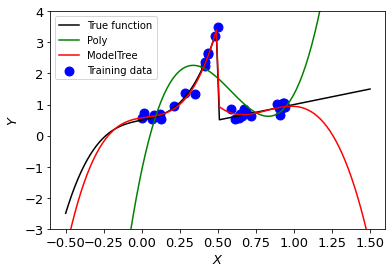

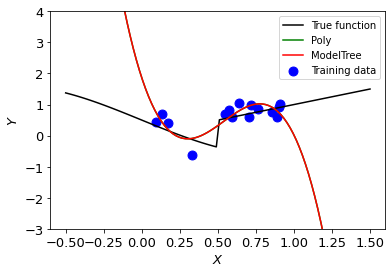

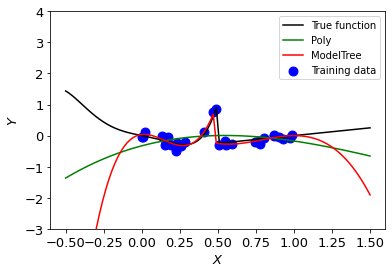

In [37]:
i = 0
samples = [30,15,30]
for f in [f_orig, f_noisy, f_step]:
    X, y = sample(samples[i], f, [0,1])
    X = np.reshape(X, (X.shape[0], 1))
    y = np.reshape(y, (y.shape[0], 1))

    poly = Poly(3)

    model = PolyTree()
    model_tree = ModelTree(model, max_depth=2, min_samples_leaf=10,
                           search_type="greedy", n_search_grid=100)

    plot([poly, model_tree], f, X, y)
    
    i+=1

In [111]:
model_tree.tree 

{'name': 'node',
 'index': 0,
 'loss': 0.04897053067202263,
 'model': <__main__.PolyTree at 0x7f32192f17b8>,
 'n_samples': 30,
 'j_feature': 0,
 'threshold': 0.46898263367448856,
 'children': {'left': {'name': 'node',
   'index': 1,
   'loss': 0.0027906722979143994,
   'model': <__main__.PolyTree at 0x7f3215b20e10>,
   'data': (array([[0.32864842],
           [0.22396609],
           [0.18324696],
           [0.46898263],
           [0.23402338],
           [0.01359039],
           [0.42572459],
           [0.23146896],
           [0.46511723],
           [0.00550218],
           [0.10866502],
           [0.29996472],
           [0.34122041]]),
    array([[-0.22892542],
           [-0.29642696],
           [-0.16746952],
           [ 0.54900712],
           [-0.20941049],
           [-0.0245364 ],
           [ 0.17601494],
           [-0.14429403],
           [ 0.64232037],
           [ 0.03624985],
           [-0.10113698],
           [-0.28959979],
           [-0.24549794]])),
   'n_